In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-22654da9-e671-c18e-b483-5daba1b1e753)


In [3]:
!pip install --upgrade tensorflow==2.11

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
   

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [4]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [5]:
import os
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/Jayms8462/tensorflow-helper-function/main/helper_functions.py
else:
    print("Already Exists, skipping download")

Already Exists, skipping download


In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [7]:
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders()
print("food101" in datasets_list)

/home/james/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [8]:
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
train_one_sample = train_data.take(1)


In [12]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape},
    Image dtype: {image.dtype},
    Target Class from food101 (tensor form): {label},
    Class Name (Str Form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3),
    Image dtype: <dtype: 'uint8'>,
    Target Class from food101 (tensor form): 38,
    Class Name (Str Form): fish_and_chips
    


In [14]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[182, 225, 242],
        [180, 223, 240],
        [179, 220, 238],
        ...,
        [157, 202, 221],
        [157, 204, 222],
        [158, 205, 223]],

       [[179, 222, 239],
        [178, 221, 238],
        [178, 219, 237],
        ...,
        [162, 207, 226],
        [162, 209, 227],
        [163, 210, 228]],

       [[178, 221, 238],
        [176, 219, 236],
        [177, 218, 236],
        ...,
        [168, 213, 232],
        [168, 215, 233],
        [167, 214, 232]],

       ...,

       [[149,  97,  39],
        [159, 109,  50],
        [156, 110,  50],
        ...,
        [108, 143, 149],
        [108, 143, 149],
        [107, 142, 148]],

       [[168, 117,  60],
        [172, 123,  65],
        [170, 125,  66],
        ...,
        [106, 141, 147],
        [106, 141, 147],
        [105, 140, 146]],

       [[183, 132,  75],
        [182, 133,  75],
        [179, 134,  75],
        ...,
        [106, 141, 14

In [15]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

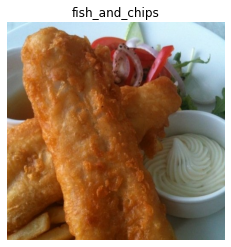

In [16]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [17]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype to float32 and reshapes image to img_shape passed in function
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [18]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDataType: {image.dtype}")
print(f"\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDataType: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[182 225 242]
  [180 223 240]
  [179 220 238]
  ...
  [157 202 221]
  [157 204 222]
  [158 205 223]]

 [[179 222 239]
  [178 221 238]
  [178 219 237]
  ...
  [162 207 226]
  [162 209 227]
  [163 210 228]]]...,
Shape: (512, 512, 3),
DataType: <dtype: 'uint8'>


Image after preprocessing:
[[[179.19897 222.19897 239.19897]
  [178.02551 219.02551 237.02551]
  [184.21428 220.78572 240.     ]
  ...
  [164.71938 206.28062 226.     ]
  [159.61736 204.61736 223.61736]
  [160.57146 207.57146 225.57146]]

 [[177.31123 220.31123 237.31123]
  [177.86224 218.86224 236.86224]
  [184.0153  221.0153  240.0153 ]
  ...
  [163.12755 203.53067 223.72963]
  [169.72447 213.00002 232.00002]
  [168.5714  214.37758 232.97449]]]...,
Shape: (224, 224, 3),
DataType: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

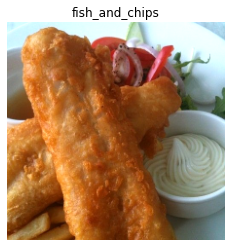

In [19]:
# Image after preprocess
plt.imshow(preprocessed_img/225.)
plt.title(class_names[label])
plt.axis(False)

# Image before preprocess
#plt.imshow(image)
#plt.title(class_names[label])
#plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

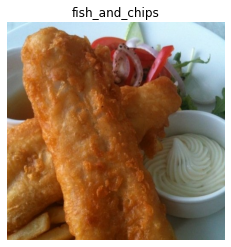

In [20]:
# Image before preprocess
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

In [21]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [23]:
from helper_functions import create_tensorboard_callback

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)
    

In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [25]:
from tensorflow.keras import layers

# Create the Model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional Model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [27]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [28]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [29]:
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        "training_logs",
        "efficientnetb0_101_classes_all_data_feature_extract"),
        model_checkpoint]
)

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20221230-203210
Epoch 1/3
2368/2368 [==============================] - 103s 40ms/step - loss: 1.7180 - accuracy: 0.5829 - val_loss: 1.1294 - val_accuracy: 0.6986
Epoch 2/3
2368/2368 [==============================] - 94s 39ms/step - loss: 1.1988 - accuracy: 0.6900 - val_loss: 1.0268 - val_accuracy: 0.7188
Epoch 3/3
2368/2368 [==============================] - 93s 39ms/step - loss: 1.0542 - accuracy: 0.7238 - val_loss: 0.9856 - val_accuracy: 0.7278


In [30]:
checkpoint_path

'model_checkpoints/cp.ckpt'

In [31]:
def create_model():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = False

    inputs = layers.Input(shape = input_shape, name="input_layer")

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x)

    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model

In [33]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-12-30 21:40:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.191.112, 142.250.191.240, 142.250.190.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.191.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  7.97MB/s    in 2.0s    

2022-12-30 21:40:38 (7.97 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [35]:
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

mkdir: cannot create directory ‘doenloaded_gs_model’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [36]:
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [38]:
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [39]:
redults_loaded_gs_model = loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 27s 32ms/step - loss: 1.0881 - accuracy: 0.7065


In [40]:
for layer in loaded_gs_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [46]:
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss")

In [48]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [51]:
loaded_gs_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics="accuracy"
)

In [52]:
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),
    reduce_lr]
)

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20221230-225636
Epoch 1/100
2368/2368 [==============================] - 366s 142ms/step - loss: 0.9224 - accuracy: 0.7529 - val_loss: 0.8150 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 335s 141ms/step - loss: 0.5789 - accuracy: 0.8394 - val_loss: 0.7866 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 324s 137ms/step - loss: 0.3328 - accuracy: 0.9051 - val_loss: 0.8141 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9492
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2368/2368 [==============================] - 322s 135ms/step - loss: 0.1738 - accuracy: 0.9492 - val_loss: 0.9369 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 315s 133

In [53]:
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [54]:
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 23s 29ms/step - loss: 1.5645 - accuracy: 0.7981


[1.564536213874817, 0.7981386184692383]

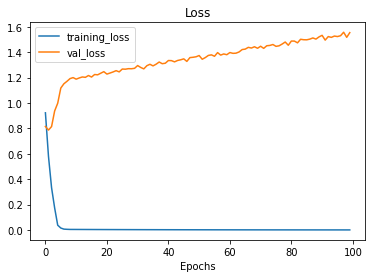

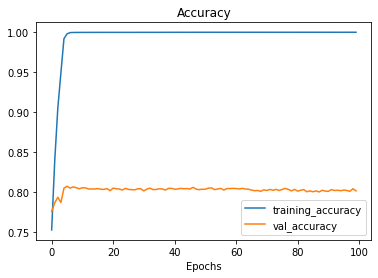

In [55]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)